# EC-Earth Heatwave Timeseries Generation

In [108]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, Country, utils
import netCDF4

import numpy as np
import pandas as pd

from scipy.ndimage import *
from scipy.interpolate import griddata

from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import os

In [2]:
DATA_ROOT = os.path.abspath("/Volumes/Samsung_T5/Thesis")
ECE_ROOT = os.path.join(DATA_ROOT, 'EC-Earth')

In [3]:
def plot_T95(T95, year):
    T95_std = T95.mean() + T95.std()

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot T95
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(T95[year], c="black", label="T95")
    plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")

    plt.ylabel("T95 (°C)")
    plt.xlabel("Date")
    plt.xticks(rotation=-90)
    plt.ylim(-3, 3)
    plt.legend()
    plt.tight_layout()
    plt.show()

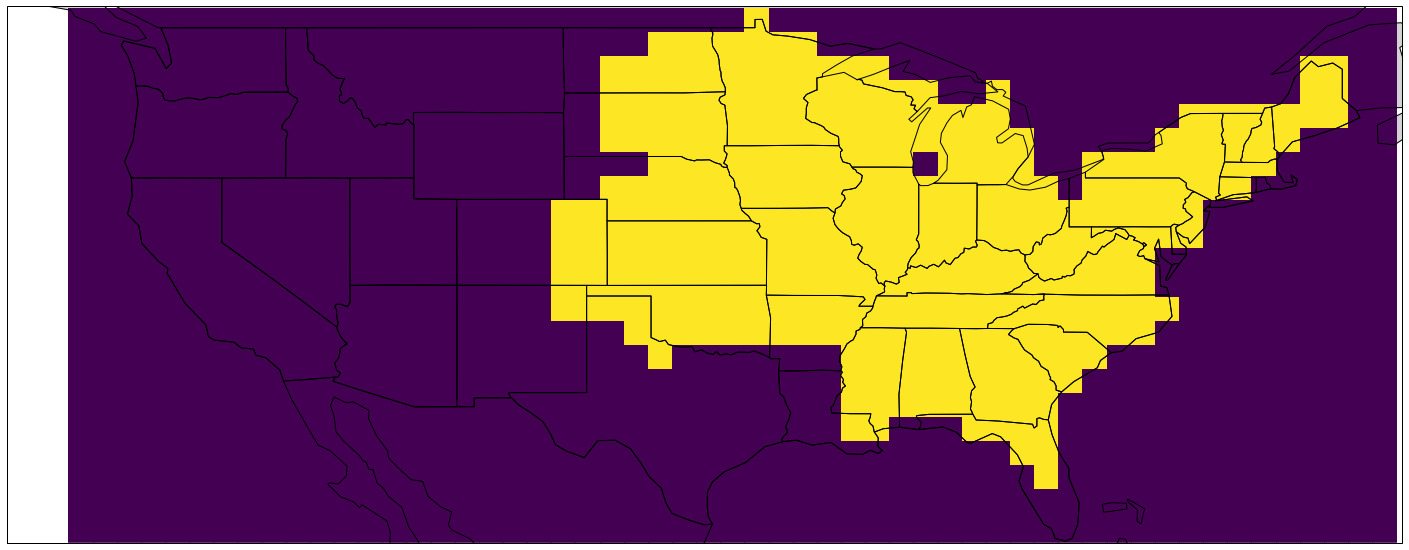

In [5]:
# Create United States Mask
TAS_PATH = os.path.join(ECE_ROOT, 'tas_PD_US/tas_d_ECEarth_PD_s01r00_2035_US.nc')
CLS_PATH = os.path.join(DATA_ROOT, "ERA", "cluster_US.nc")

# Use ERA LandSeaMask to solve for the lack of one in EC-Earth
TAS = ERA(TAS_PATH, 'tas', latitude_key='lat', longitude_key='lon')
CLS = netCDF4.Dataset(CLS_PATH)['mask'][:]

TAS_GRID = utils.era_coordinate_grid(TAS_PATH).reshape(-1, 2)
CLS_GRID = utils.era_coordinate_grid(CLS_PATH).reshape(-1, 2)

CLS_INTERP = griddata(CLS_GRID, CLS.ravel(), TAS_GRID).reshape(TAS.shape[1:]).astype(np.bool)

MASK_US = (utils.era_country_mask(TAS_PATH) == Country.US) * CLS_INTERP

utils.plot_earth("US")
plt.pcolormesh(TAS.longitude, TAS.latitude, MASK_US)
plt.show()

In [6]:
MAX_SESSION = 16
MAX_REPETITION = 24
YEARS = [2036, 2037, 2038, 2039]

SUMMER_START_DAY = 174
SUMMER_STOP_DAY = 234

In [17]:
def walk():
    for session in range(MAX_SESSION):
        for repetition in range(MAX_REPETITION):
            for i, year in enumerate(YEARS):
                year_code = f"{session+1:02d}{repetition*len(YEARS)+i:02d}"

                yield session, repetition, year, year_code

In [18]:
# Load Data for Eastern US cluster from Disk
extra_days = 3

TAS = []

for session, repetition, year, year_code in walk():
            
    TAS_ = ERA(os.path.join(ECE_ROOT, f'tas_PD_US/tas_d_ECEarth_PD_s{session+1:02d}r{repetition:02d}_{year:04d}_US.nc'),
               'tas', latitude_key='lat', longitude_key='lon', time_unit='d', time_origin=f'{year}-01-01',
               index=[slice(SUMMER_START_DAY-extra_days, SUMMER_STOP_DAY+extra_days)])

    if len(TAS_.time) == 366:
        period = pd.period_range(f"{year_code}-06-{23-extra_days}", f"{year_code}-08-{21+extra_days}")
    else:
        period = pd.period_range(f"{year_code}-06-{24-extra_days}", f"{year_code}-08-{22+extra_days}")

    TAS.append(pd.DataFrame(TAS_.data[:, MASK_US], index=period))

    print(f"\rLoading {year_code}", end="")

TAS = pd.concat(TAS)

Loading 1695

In [8]:
# T95 is 95th Spatial Percentile of US Summer Anomalies
T95 = TAS.groupby([TAS.index.month, TAS.index.day]).apply(lambda x: x - x.mean()).quantile(0.95, 1)
T95 = (T95 - T95.mean()) / T95.std()
T95_mean = T95.rolling(7, center=True).mean()

# Remove Extra Days from Dataset
T95 = pd.concat([data[extra_days:-extra_days] for year, data in T95.groupby(T95.index.year)])
T95_mean = pd.concat([data[extra_days:-extra_days] for year, data in T95_mean.groupby(T95_mean.index.year)])

T95.to_csv(os.path.join(DATA_ROOT, 'heatwave_ECE.csv'))
T95_mean.to_csv(os.path.join(DATA_ROOT, 'heatwave_ECE_mean.csv'))

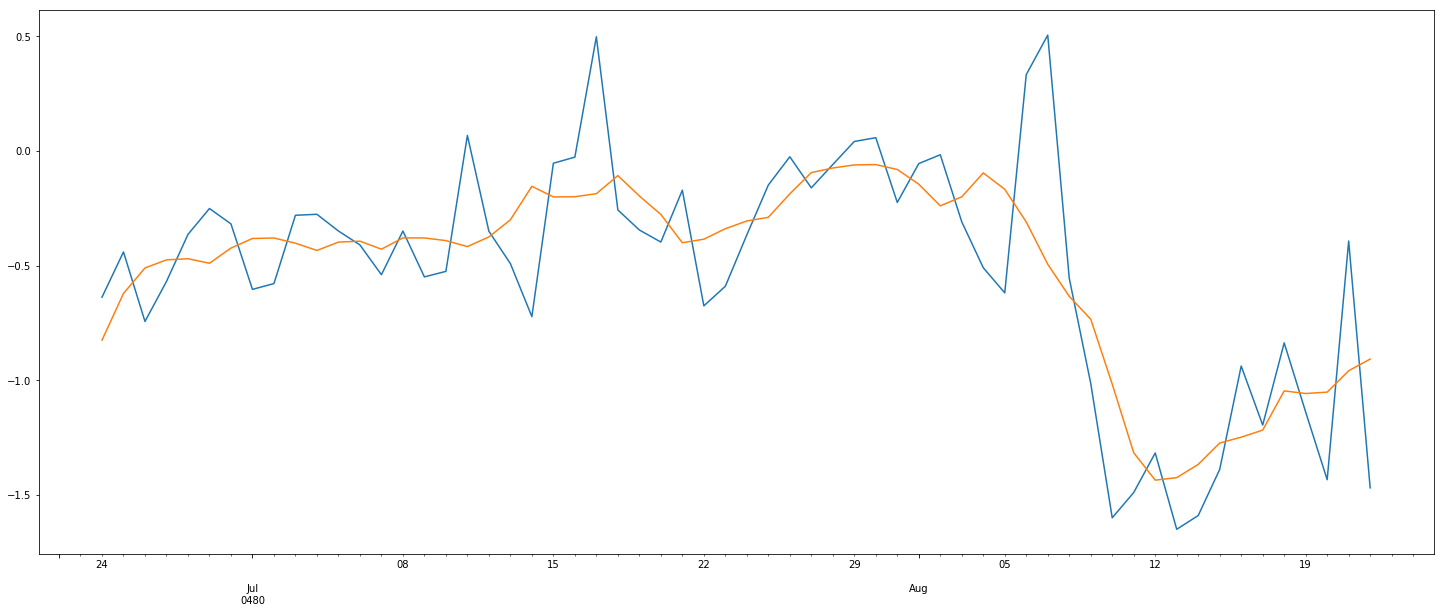

In [9]:
YEAR = 480

T95[T95.index.year == YEAR].plot()
T95_mean[T95.index.year == YEAR].plot()
plt.show()

# Create Sea Surface Temperature (SST) Anomalies + Composite

In [92]:
LAG = 50

COUNT = 0

TOS_MEAN = np.zeros((60, 160, 320), np.float64)

# Calculate SST MEAN
for session, repetition, year, year_code in walk():
    print(f"\rLoading {year_code}", end="")

    PATH = os.path.join(ECE_ROOT, f'tos_d_s{session+1:02d}', f'tos_d_ECEarth_PD_s{session+1:02d}r{repetition:02d}_{year:04d}.nc')
    TOS_ = ERA(PATH, 'tos', index=[slice(SUMMER_START_DAY-LAG, SUMMER_STOP_DAY-LAG)], latitude_key='lat', longitude_key='lon', time_origin=f'{year}-01-01')

    TOS_MEAN += TOS_.data
    COUNT += 1
    
TOS_MEAN /= COUNT

TOS_COMP = np.zeros((60, 160, 320), np.float64)

# Calculate SST Composite
for session, repetition, year, year_code in walk():
    print(f"\rLoading {year_code}", end="")
    
    PATH = os.path.join(ECE_ROOT, f'tos_d_s{session+1:02d}', f'tos_d_ECEarth_PD_s{session+1:02d}r{repetition:02d}_{year:04d}.nc')
    TOS_ = ERA(PATH, 'tos', index=[slice(SUMMER_START_DAY-LAG, SUMMER_STOP_DAY-LAG)], latitude_key='lat', longitude_key='lon', time_origin=f'{year}-01-01')
    
    HOT_DAYS = T95[T95.index.year == int(year_code)].values > 1
    
    TOS_COMP += (TOS_.data - TOS_MEAN) * HOT_DAYS[:, None, None]
    
TOS_COMP = TOS_COMP.sum(0)
TOS_COMP /= TOS_COMP[TOS_COMP != 0.0].std()

Loading 1695

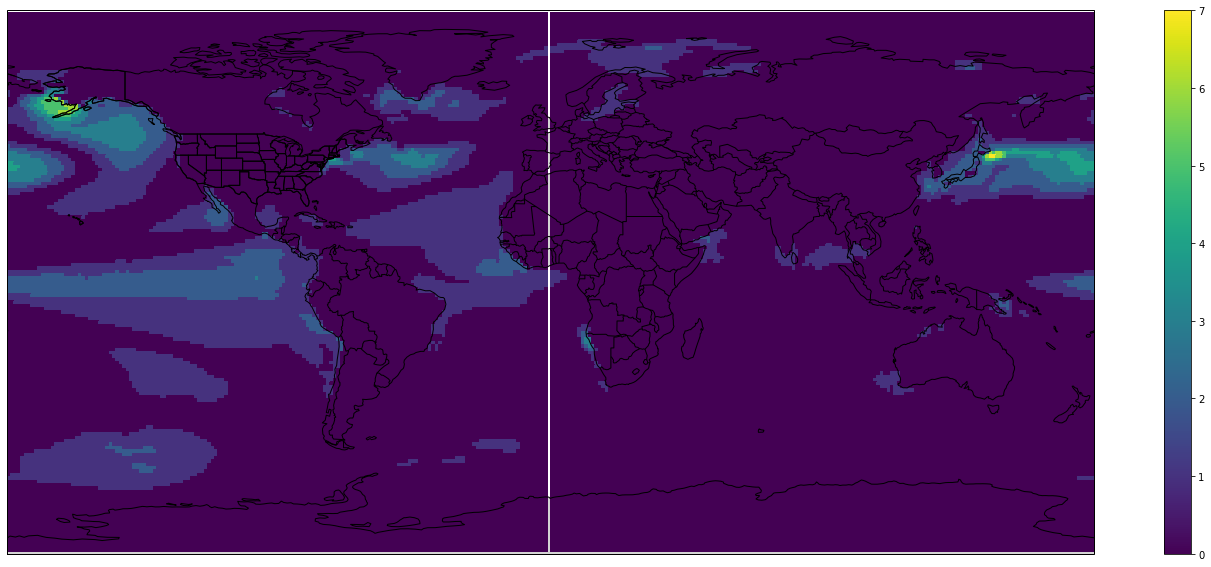

In [120]:
utils.plot_earth()
plt.pcolormesh(TOS_.longitude, TOS_.latitude, (np.abs(TOS_COMP)).astype(np.int32))
plt.colorbar()
plt.show()